In [2]:
import os
import collections
from datetime import datetime, timedelta
from functools import partial
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from kaggle_datasets import KaggleDatasets
from torchvision import datasets, transforms ,utils,models
import efficientnet.tfkeras as efn

from tensorflow.keras.applications import ResNet50V2,ResNet101V2,ResNet152V2,DenseNet201
import cv2
import torch.nn.functional as F
import torch.nn as nn
import os
import shutil
import torch
from torchvision import transforms
from PIL import Image
import pathlib
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.4


In [3]:
!ls

__notebook_source__.ipynb


In [4]:
# Create strategy from tpu
istpu=False
if istpu:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [5]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [512, 512]
EPOCHS = 20


In [6]:
test = pd.read_csv('../input/test_ApKoW4T.csv')
sample = pd.read_csv('../input/sample_submission_ns2btKE.csv')
train = pd.read_csv('../input/train/train.csv')

In [7]:
convertlabeldict = {1: 'Cargo', 
2:'Military', 
3:'Carrier', 
4:'Cruise', 
5:'Tankers'}
train['category_label'] = train['category'].map(convertlabeldict)

In [8]:
train.head()

,image,category,category_label
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


In [9]:
train, holdout = train_test_split(train, test_size=0.2, random_state=0, 
                               stratify=train['category'])

In [10]:
train = train.reset_index(drop=True)
train.head()

,image,category,category_label
0,2827293.jpg,1,Cargo
1,2324207.jpg,4,Cruise
2,2816925.jpg,5,Tankers
3,2903004.jpg,3,Carrier
4,2884341.jpg,1,Cargo


In [11]:
holdout = holdout.reset_index(drop=True)
holdout.head()

,image,category,category_label
0,2835355.jpg,5,Tankers
1,2491051.jpg,4,Cruise
2,2862151.jpg,5,Tankers
3,2888474.jpg,1,Cargo
4,697630.jpg,2,Military


In [12]:
test = test.reset_index(drop=True)
test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [13]:
train['category'].value_counts()

1    1696
5     973
2     933
3     733
4     666
Name: category, dtype: int64

In [14]:
holdout['category'].value_counts()

1    424
5    244
2    234
3    183
4    166
Name: category, dtype: int64

In [15]:
def copy_files_local(df,basedir,destinationfolder):
    for i,row in df.iterrows():
        currentfileloc = basedir + row['image']
        if not os.path.exists(destinationfolder):
            os.makedirs(destinationfolder)
        shutil.copy(currentfileloc, destinationfolder)

In [16]:
copy_files_local(train,'../input/train/images/','../train/')
copy_files_local(holdout,'../input/train/images/','../holdout/')
copy_files_local(test,'../input/train/images/','../test/')

In [17]:
!ls ../train/ | wc -l
!ls ../holdout/ | wc -l
!ls ../test/ | wc -l


5001
1251
2680


In [18]:
def get_filenames(df,category,image_num):
    return random.sample(df[df.category==category]['image'].tolist(),image_num)

def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    rand = random.uniform(0.6, 1.0)
    hsv[:, :, 2] = rand*hsv[:, :, 2]
    rand = random.uniform(1.0, 1.5)
    hsv[:, :, 1] = rand*hsv[:, :, 1]
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img


def zoom(image,rows,cols):
    zoom_pix = random.randint(5, 10)
    zoom_factor = 1 + (2*zoom_pix)/rows
    image = cv2.resize(image, None, fx=zoom_factor,
                       fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    top_crop = (image.shape[0] - rows)//2
    left_crop = (image.shape[1] - cols)//2
    image = image[top_crop: top_crop+rows,
                  left_crop: left_crop+cols]
    return image

In [19]:
import random

def createaugimagesv2(df,category,image_num,dirname):
    filename = get_filenames(df,category,image_num)
    for images in filename:
        if images[-8:]!='_enh.jpg' and images[-9:]!='_enh1.jpg':
            imagepath = dirname + images
            image = cv2.imread(imagepath)
            rows,cols,channel = image.shape
            image = np.fliplr(image)

            op1 = random.randint(0, 1)
            op2 = random.randint(0, 1)
            op3 = random.randint(0, 1)
            if op1:
                image = random_brightness(image)
            if op2:
                image = zoom(image,rows,cols)
            newimagepath = dirname + images.split('.')[0]+'_'+str(category) + '_enh.jpg'
            try:
                image = cv2.resize(image, (224, 224))
                cv2.imwrite(newimagepath, image)
            except:
                print("file {0} is not converted".format(images))

In [20]:
import random
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

def createaugimages(df,category,image_num,dirname):
    filename = get_filenames(df,category,image_num)
    for images in filename:
        if images[-9:]!='_enh1.jpg':
            imagepath = dirname + images
            pil_im = Image.open(imagepath, 'r').convert('RGB')
            op1 = random.randint(0, 1)
            if op1 ==1:
                changeimg = transforms.Compose([ 
                                        transforms.RandomRotation(5),
                                        transforms.Resize(224),
                                        transforms.ToTensor()
                                       ])
            else:
                changeimg = transforms.Compose([ 
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(10),
                            transforms.Resize(224),
                            transforms.ToTensor()
                           ])

            img = changeimg(pil_im)
            newimagepath = dirname + images.split('.')[0]+'_'+str(category) + '_enh1.jpg'
            utils.save_image(img,newimagepath)   

In [21]:
def resizeall(dirname):
    filename = os.listdir(dirname)
    non3channel = []
    for images in filename:
        imagepath = dirname + images
        image = cv2.imread(imagepath)
        if image.shape[2] !=3:
            non3channel.append(images)
    return non3channel

In [22]:
convertlabeldict = {1: 'Cargo', 
2:'Military', 
3:'Carrier', 
4:'Cruise', 
5:'Tankers'}

In [23]:
a = 1908 - 1095
b = 1908 - 1050
c = 1908 - 824
d = 1908 - 749

In [24]:
#1    1696
#5     973
#2     933
#3     733
#4     666

In [25]:
createaugimagesv2(train,5,1696 - 1095,'../train/')
createaugimagesv2(train,2,1696 - 1050,'../train/')


In [26]:
createaugimagesv2(train,3,733,'../train/')
createaugimagesv2(train,4,666,'../train/')

In [27]:
createaugimages(train,1,500,'../train/')
createaugimages(train,5,500,'../train/')
createaugimages(train,2,500,'../train/')
createaugimages(train,3,733,'../train/')
createaugimages(train,4,666,'../train/')

In [28]:
createaugimagesv2(train,3,288,'../train/')
createaugimagesv2(train,4,400,'../train/')

In [29]:
train.shape

(5001, 3)

In [30]:
data_dir = '../train/'
data_dir = pathlib.Path(data_dir)
enh_files = list(data_dir.glob('*_enh.jpg'))
enh_files1 = list(data_dir.glob('*_enh1.jpg'))
allfiles = enh_files+enh_files1

In [31]:
len(allfiles),len(set(allfiles))

(5545, 5545)

In [32]:
train = train.reset_index(drop=False)
train.head()

,index,image,category,category_label
0,0,2827293.jpg,1,Cargo
1,1,2324207.jpg,4,Cruise
2,2,2816925.jpg,5,Tankers
3,3,2903004.jpg,3,Carrier
4,4,2884341.jpg,1,Cargo


In [33]:
holdout = holdout.reset_index(drop=False)
holdout.head()

,index,image,category,category_label
0,0,2835355.jpg,5,Tankers
1,1,2491051.jpg,4,Cruise
2,2,2862151.jpg,5,Tankers
3,3,2888474.jpg,1,Cargo
4,4,697630.jpg,2,Military


In [34]:
test = test.reset_index(drop=False)
test.head()

,index,image
0,0,1007700.jpg
1,1,1011369.jpg
2,2,1051155.jpg
3,3,1062001.jpg
4,4,1069397.jpg


In [35]:
enh_df = pd.DataFrame()
i = max(train['index'])
for file in allfiles:
    st = str(file)
    cat = st.split('_')[1]
    st = st.split('/')[-1]
    i = i+1
    enh_df = enh_df.append({'index': int(i), 'image': st, 'category': int(cat),'category_label':convertlabeldict[int(cat)]}, ignore_index=True)

In [36]:
enh_df['index']=enh_df['index'].apply(int)
train = pd.concat([train,enh_df]).reset_index(drop=True)
train.head()

,index,image,category,category_label
0,0,2827293.jpg,1.0,Cargo
1,1,2324207.jpg,4.0,Cruise
2,2,2816925.jpg,5.0,Tankers
3,3,2903004.jpg,3.0,Carrier
4,4,2884341.jpg,1.0,Cargo


In [37]:
def null_finder(df):
    for col in df.columns.tolist():
        print("For column {0} : NULLS are {1}".format(col,sum(df[col].isnull())))

In [38]:
null_finder(train)

For column index : NULLS are 0
For column image : NULLS are 0
For column category : NULLS are 0
For column category_label : NULLS are 0


In [39]:
null_finder(holdout)

For column index : NULLS are 0
For column image : NULLS are 0
For column category : NULLS are 0
For column category_label : NULLS are 0


In [40]:
null_finder(test)

For column index : NULLS are 0
For column image : NULLS are 0


In [41]:

!ls ../train/ | wc -l
!ls ../holdout/ | wc -l
!ls ../test/ | wc -l


10546
1251
2680


../train/2862082_5_enh.jpg


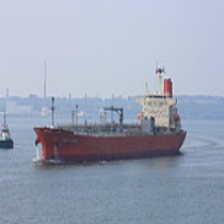

../train/2847709_5_enh.jpg


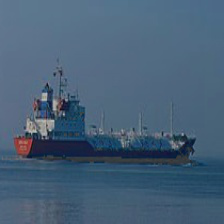

../train/2807234_4_enh.jpg


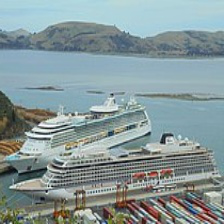

In [42]:
data_dir = '../train/'
data_dir = pathlib.Path(data_dir)
roses = list(data_dir.glob('*_enh.jpg'))
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
for image_path in roses[:3]:
    print(image_path)
    display.display(Image.open(str(image_path)))

In [43]:
BATCH_SIZE = 64
img_size = 224
train_image_count = 10546
hold_image_count = 1251
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
STEPS_PER_EPOCH_HOLD = np.ceil(hold_image_count/BATCH_SIZE)
STEPS_PER_EPOCH,STEPS_PER_EPOCH_HOLD

(165.0, 20.0)

In [44]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    #img = tf.cast(image, tf.float32) / 255.0 
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [img_size, img_size])

def get_images_label(image,label):
    img = tf.io.read_file(image)
    img = decode_img(img)
    label = tf.cast(label, tf.int32)
    return img,label

def convert_cat(image,label):
    label = tf.convert_to_tensor(tf.keras.utils.to_categorical(label, num_classes=5, dtype='float32'))
    return image,label

def get_images_id(image,ids):
    img = tf.io.read_file(image)
    img = decode_img(img)
    ids = tf.cast(ids, tf.int32)
    return img,ids

def data_augment(image, label, seed=2020):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image, seed=seed)
#    image = tf.image.random_flip_up_down(image, seed=seed)
#    image = tf.image.random_brightness(image, 0.1, seed=seed)
#    image = tf.image.random_jpeg_quality(image, 85, 100, seed=seed)
#    image = tf.image.resize(image, [256, 256])
#    image = tf.image.central_crop(image, [224, 224])
#    image = tf.image.random_crop(image, [224, 224], seed=seed)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label 

def data_reshape(image,label,seed=2020):
#    image = tf.image.resize(image, [256, 256])
    #image = tf.image.central_crop(image, [224, 224])
    image = tf.image.random_crop(image, [img_size, img_size], seed=seed)
    return image,label
    

def get_training_dataset(dataset):
    dataset = dataset.map(get_images_label, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    #dataset = dataset.map(convert_cat, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(BATCH_SIZE * 50)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(get_images_label, num_parallel_calls=AUTOTUNE)
    #dataset = dataset.map(data_reshape, num_parallel_calls=AUTO)
    #dataset = dataset.map(convert_cat, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(dataset):
    dataset = dataset.map(get_images_id, num_parallel_calls=AUTOTUNE)
    #dataset = dataset.map(data_reshape, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [45]:
#BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES =[1,2,3,4,5]

dataset_train = tf.data.Dataset.from_tensor_slices(('../train/'+train['image'].values,np.array(pd.get_dummies(train['category'].values))))
dataset_holdout = tf.data.Dataset.from_tensor_slices(('../holdout/'+holdout['image'].values,np.array(pd.get_dummies(holdout['category'].values))))
dataset_test = tf.data.Dataset.from_tensor_slices(('../test/'+test['image'].values,test['index'].values))

2023-01-17 16:33:20.893179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:33:20.894304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:33:20.895183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 16:33:20.898597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [46]:
final_ds_train = get_training_dataset(dataset_train)
final_ds_holdout = get_training_dataset(dataset_holdout)
final_ds_test = get_test_dataset(dataset_test)

In [47]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        value = label_batch.numpy().tolist()
        value = value[n].index(1) + 1
        plt.title(convertlabeldict[value])
        plt.axis('off')

In [48]:
image_batch, label_batch = next(iter(final_ds_train))

2023-01-17 16:33:26.504662: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


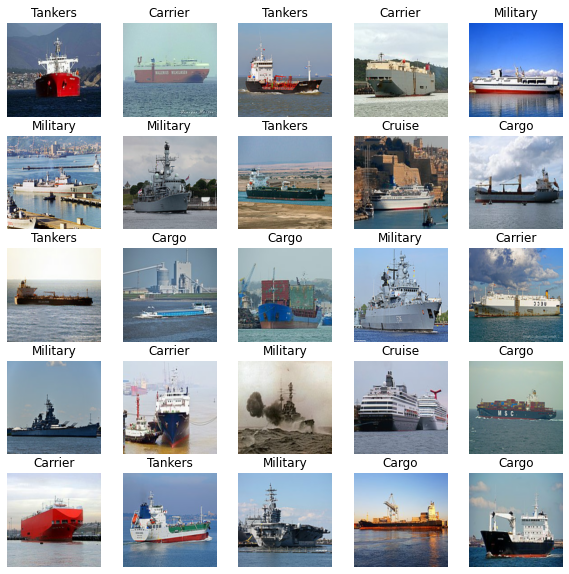

In [49]:

show_batch(image_batch, label_batch)

In [50]:
for image,caregory in final_ds_holdout.take(5):
    print(image.shape,caregory.shape)

(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)


In [51]:
convertlabeldict

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

In [52]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [53]:
#with strategy.scope():
enet=False
if enet:
    features_model = efn.EfficientNetB7(
        input_shape=(256, 256, 3),
        weights='imagenet',
        include_top=False
    )
else:
    features_model = DenseNet201(
        input_shape=(img_size, img_size, 3),
        weights='imagenet',
        include_top=False
    )

model = tf.keras.Sequential([
    features_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    #optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    optimizer=tf.keras.optimizers.Adam(lr=0.00001),
    #optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
    #loss = 'categorical_crossentropy',
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()]
    #metrics = tf.keras.metrics.sparse_categorical_accuracy()
    loss = 'categorical_crossentropy',
    #loss = macro_f1,
    metrics=['categorical_accuracy']
)
model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 18,568,517
Trainable params: 18,339,461
Non-trainable params: 229,056
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [55]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(
    final_ds_train, 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, 
    validation_data=final_ds_holdout,
    validation_steps=STEPS_PER_EPOCH_HOLD,
    #validation_data=dataset_holdout
    callbacks=[lr_schedule]
)

Epoch 1/15


2023-01-17 16:34:05.380900: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-17 16:34:11.888956: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-17 16:34:13.013930: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-17 16:34:13.041266: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

165/165 [==============================] - 130s 601ms/step - loss: 1.7487 - categorical_accuracy: 0.2863 - val_loss: 2.7458 - val_categorical_accuracy: 0.1187
Epoch 2/15
165/165 [==============================] - 96s 584ms/step - loss: 1.2788 - categorical_accuracy: 0.4402 - val_loss: 3.1426 - val_categorical_accuracy: 0.1492
Epoch 3/15
165/165 [==============================] - 96s 579ms/step - loss: 1.0177 - categorical_accuracy: 0.5871 - val_loss: 2.9553 - val_categorical_accuracy: 0.1633
Epoch 4/15
165/165 [==============================] - 96s 580ms/step - loss: 0.8097 - categorical_accuracy: 0.6696 - val_loss: 7.4558 - val_categorical_accuracy: 0.3734
Epoch 5/15
165/165 [==============================] - 96s 584ms/step - loss: 0.6468 - categorical_accuracy: 0.7387 - val_loss: 6.6242 - val_categorical_accuracy: 0.3945
Epoch 6/15
165/165 [==============================] - 96s 582ms/step - loss: 0.5493 - categorical_accuracy: 0.7798 - val_loss: 1.8611 - val_categorical_accuracy: 0.6

In [56]:
history.history

{'loss': [1.748733401298523,
  1.278831124305725,
  1.0176599025726318,
  0.8097448945045471,
  0.6467880606651306,
  0.5492884516716003,
  0.6626928448677063,
  0.5743523240089417,
  0.4941093325614929,
  0.42223215103149414,
  0.3237527906894684,
  0.26125773787498474,
  0.2365180253982544,
  0.20194517076015472,
  0.1753407120704651],
 'categorical_accuracy': [0.286268949508667,
  0.44015151262283325,
  0.5871211886405945,
  0.6696022748947144,
  0.7387310862541199,
  0.7798295617103577,
  0.7410038113594055,
  0.7740530371665955,
  0.8113636374473572,
  0.8397727012634277,
  0.8752840757369995,
  0.9042613506317139,
  0.9130681753158569,
  0.9232954382896423,
  0.9346590638160706],
 'val_loss': [2.7457661628723145,
  3.1425881385803223,
  2.9553017616271973,
  7.455836296081543,
  6.62424373626709,
  1.8610996007919312,
  3.0450141429901123,
  1.2838084697723389,
  3.0338213443756104,
  0.5367869734764099,
  0.6571646928787231,
  0.5023636817932129,
  0.5933839678764343,
  0.466622

In [57]:
from collections import Counter

In [58]:

probabilities = model.predict(final_ds_test)
predictions = np.argmax(probabilities, axis=-1) +1


2023-01-17 16:58:33.410559: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [59]:
print(Counter(predictions))

Counter({1: 1113, 5: 515, 2: 395, 3: 376, 4: 281})


In [60]:
print('Generating submission.csv file...')
test_ids_ds = final_ds_test.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(2680))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Generating submission.csv file...


In [61]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

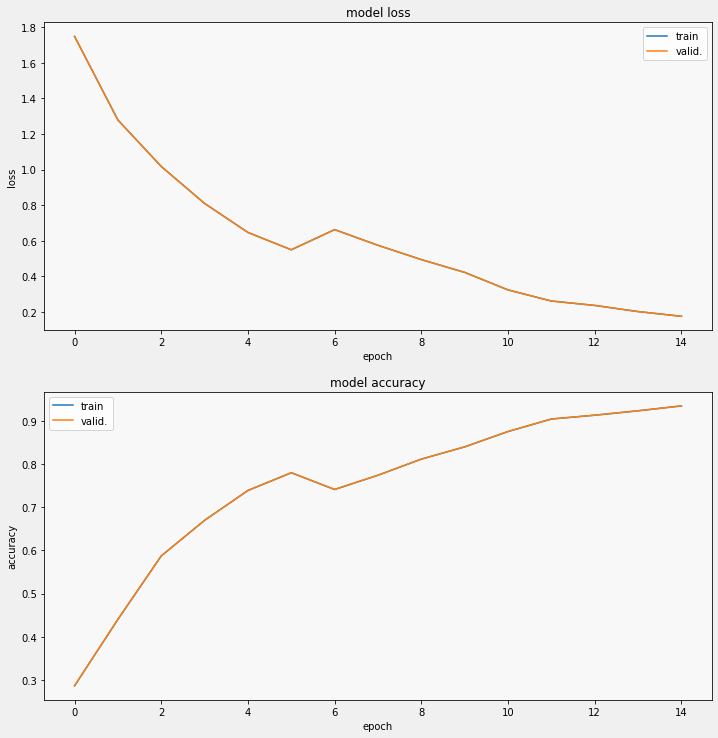

In [62]:
display_training_curves(history.history['loss'], history.history['loss'], 'loss', 211)
display_training_curves(history.history['categorical_accuracy'], history.history['categorical_accuracy'], 'accuracy', 212)

In [65]:
print('Final Accuracy =',history.history['categorical_accuracy'][-1])

Final Accuracy = 0.9346590638160706
